In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
full_pathb='/content/drive/MyDrive/hdb_price_prediction.csv'

In [ ]:
# Setting the seed here is sufficient.
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [ ]:
len(df['storey_range'].unique())

17

In [ ]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [ ]:
from keras import backend as K

def r2(y_true, y_pred):
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# **Qn 1**
a. Divide dataset into train and test sets by using entries from year 2020 & before as training data.

Why is this done instead of using random train/test splits?

In [ ]:
#Creating the Dataset for training and testing
temp_df = df.copy()
temp_df_train = temp_df[temp_df['year'] <= 2020].copy()
temp_df_val = temp_df[temp_df['year'] >= 2021].copy()
temp_df_train = temp_df_train[['dist_to_nearest_stn', 'dist_to_dhoby',  'degree_centrality', 'eigenvector_centrality',
                  'remaining_lease_years', 'floor_area_sqm', 'month', 'flat_model_type', 'storey_range', 'resale_price']]
temp_df_val = temp_df_val[['dist_to_nearest_stn', 'dist_to_dhoby',  'degree_centrality', 'eigenvector_centrality',
                  'remaining_lease_years', 'floor_area_sqm', 'month', 'flat_model_type', 'storey_range', 'resale_price']]

It is done because of relevance according to length of time. Patterns in previous years would be a better learning tools for the nerual network than random split of train/tests.

In [ ]:
# Split data

train_dataframe = temp_df_train # TODO
val_dataframe = temp_df_val # TODO

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

# **Qn 1**
b. A team of data scientist implimented a linear regression model vila Scikit-learn. Obtained a test of R-squared value of 0.627.

Implement this neural network by following tutorial from Keras documentation. Architecture should resemble figure shown in Appendix A.

In [ ]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

all_inputs = [
    month,
    flat_model_type,
    storey_range,
    floor_area_sqm,
    remaining_lease_years,
    degree_centrality,
    eigenvector_centrality,
    dist_to_nearest_stn,
    dist_to_dhoby
]

# Integer categorical features
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded]
)

# **Qn 1**
c. The team suggests to train the model for 50 epochs using mini-batch gradient descent with batch size 256, Adam optimiser and m.s.e as cost function. However, you find that your results are far off from model.

Change to SGD and observe how problem is fixed.

Report the test R-squared value and explain why the change to SGD fixes the problem faced in Adam optimiser.

In [ ]:
#Compiling the Model and defining the optimizer, metrics, and loss
output = layers.Dense(1)(all_features)
model_adam = keras.Model(all_inputs, output)
opt = keras.optimizers.Adam()
model_adam.compile(opt, "mean_squared_error", metrics=[r2])

In [ ]:
#fitting the model with the training data and checking the loss/accuracy with testing data
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
342/342 [==============================] - 1s 4ms/step - loss: 219581906944.0000 - r2: -8.3534 - val_loss: 301481820160.0000 - val_r2: -10.0933
Epoch 2/50
342/342 [==============================] - 1s 3ms/step - loss: 219580465152.0000 - r2: -8.3588 - val_loss: 301480214528.0000 - val_r2: -10.0807
Epoch 3/50
342/342 [==============================] - 1s 3ms/step - loss: 219579154432.0000 - r2: -8.3384 - val_loss: 301478608896.0000 - val_r2: -10.0828
Epoch 4/50
342/342 [==============================] - 1s 3ms/step - loss: 219577860096.0000 - r2: -8.3494 - val_loss: 301477199872.0000 - val_r2: -10.0805
Epoch 5/50
342/342 [==============================] - 1s 3ms/step - loss: 219576598528.0000 - r2: -8.3421 - val_loss: 301475463168.0000 - val_r2: -10.0823
Epoch 6/50
342/342 [==============================] - 1s 3ms/step - loss: 219575222272.0000 - r2: -8.3467 - val_loss: 301474021376.0000 - val_r2: -10.0859
Epoch 7/50
342/342 [==============================] - 1s 3ms/step - lo

Test Data R-squared Value for the above model with Adam Optmizer is -10.0767, the Best model had R^2 value of -10.0644 (will vary do check and update if needed)

Changing the Optimizer to SGD

In [ ]:
#compiling the model
output = layers.Dense(1)(all_features)
model = keras.Model(all_inputs, output)
model.compile("SGD", "mean_squared_error", metrics=[r2])

In [ ]:
#fitting the model
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
342/342 [==============================] - 2s 4ms/step - loss: 18739302400.0000 - r2: 0.2091 - val_loss: 13706268672.0000 - val_r2: 0.4993
Epoch 2/50
342/342 [==============================] - 1s 3ms/step - loss: 5481937408.0000 - r2: 0.7679 - val_loss: 12800084992.0000 - val_r2: 0.5318
Epoch 3/50
342/342 [==============================] - 1s 3ms/step - loss: 5026530304.0000 - r2: 0.7874 - val_loss: 12430424064.0000 - val_r2: 0.5458
Epoch 4/50
342/342 [==============================] - 1s 3ms/step - loss: 4777321984.0000 - r2: 0.7979 - val_loss: 12197406720.0000 - val_r2: 0.5542
Epoch 5/50
342/342 [==============================] - 1s 3ms/step - loss: 4607572992.0000 - r2: 0.8048 - val_loss: 11929927680.0000 - val_r2: 0.5640
Epoch 6/50
342/342 [==============================] - 1s 3ms/step - loss: 4482378752.0000 - r2: 0.8098 - val_loss: 11740258304.0000 - val_r2: 0.5703
Epoch 7/50
342/342 [==============================] - 1s 3ms/step - loss: 4383887360.0000 - r2: 0.8142 - 

Test Data R-squared Value for the above model with SGD Optmizer is 0.6123

By implementation, SGD should be able to generalize better (i.e. perform better on test data) than Adam, while Adam optmizer is combination of RMSprop and AdaGrad, so Adam will be able to take less steps than SGD to find the min loss for the given model.
Given case Adam optimzer learning rate is too low for this to converge to a minimum loss.

# **Qn 1**
d. Add 1 hidden layer(10 units) to the architecture in Qn 1c  and train it with the same config as in Qn 1c excepth that the learning rate is increased to 0.008. Report R-squared value.

In [ ]:
#compiling the model
x = layers.Dense(10, activation='relu')(all_features)
output = layers.Dense(1)(x)
model = keras.Model(all_inputs, output)
opt = keras.optimizers.Adam(0.08)
model.compile(opt, "mean_squared_error", metrics=[r2])

In [ ]:
#getting a summary of the model to visualizer the model
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 flat_model_type (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 storey_range (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 floor_area_sqm (InputLayer)    [(None, 1)]          0           []                               
                                                                                           

In [ ]:
#fitting the model
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
342/342 [==============================] - 2s 4ms/step - loss: 203619663872.0000 - r2: -7.6720 - val_loss: 240689430528.0000 - val_r2: -7.8529
Epoch 2/50
342/342 [==============================] - 1s 3ms/step - loss: 116582391808.0000 - r2: -3.9537 - val_loss: 113551368192.0000 - val_r2: -3.1683
Epoch 3/50
342/342 [==============================] - 1s 3ms/step - loss: 35543384064.0000 - r2: -0.5061 - val_loss: 36930650112.0000 - val_r2: -0.3534
Epoch 4/50
342/342 [==============================] - 1s 3ms/step - loss: 8619563008.0000 - r2: 0.6352 - val_loss: 16415982592.0000 - val_r2: 0.4006
Epoch 5/50
342/342 [==============================] - 1s 3ms/step - loss: 5349275648.0000 - r2: 0.7740 - val_loss: 13007073280.0000 - val_r2: 0.5249
Epoch 6/50
342/342 [==============================] - 1s 3ms/step - loss: 4915016704.0000 - r2: 0.7918 - val_loss: 12217957376.0000 - val_r2: 0.5538
Epoch 7/50
342/342 [==============================] - 1s 3ms/step - loss: 4642394624.0000 - r

The best R-squared value is 0.626

# **Qn 1**
e. Cimpare the performance of the linear regression model to the Dense layer and the NN architecture and suggest reasons for the observations you made.

On comparison to linear model, This model similarly, which is visible from the  very small difference in R-squared value.

# **Qn 2**
a. Further split the data from the year 2020 and before by using data from year 2020 as validation set and the rest as the training set.

In [ ]:
#Creating a new dataset for question 2
q2 = df.copy()
q2_train = q2[q2['year'] < 2020]
q2_val = q2[q2['year'] == 2020]
q2_train = q2_train[['dist_to_nearest_stn', 'dist_to_dhoby',  'degree_centrality', 'eigenvector_centrality',
                  'remaining_lease_years', 'floor_area_sqm', 'month', 'flat_model_type', 'storey_range', 'resale_price']]
q2_val = q2_val[['dist_to_nearest_stn', 'dist_to_dhoby',  'degree_centrality', 'eigenvector_centrality',
                  'remaining_lease_years', 'floor_area_sqm', 'month', 'flat_model_type', 'storey_range', 'resale_price']]

In [ ]:
#Defining the new functions to match requirements of the question
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    labels =tf.cast(labels,tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

def encode_categorical_feature2(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [ ]:
# Split data

train_dataframe = q2_train # TODO
val_dataframe = q2_val # TODO

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

# **Qn 2**
b. For each categorical variable, replace the one-hot encodinf with the layer tf.keras.Embedding(). Set output_dim floor...

The embedding layer produces a 2D output, which cannot be concatenated with other features. Add a Flatten layer to resolve this.

In [ ]:
#importing the required libraries
from math import floor
import keras_tuner
from keras import callbacks

In [ ]:
#Defininf the model using function for the purpose of hyperparameter tuning
def q2_build_model(hp):

    # Categorical features encoded as integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")

    # Categorical feature encoded as string
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

    # Numerical features
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

    all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]

    # Integer categorical features
    month_encoded = encode_categorical_feature2(month, "month", train_ds, False)
    month_embedded = layers.Embedding(13,output_dim = int(12/hp.Int('divisor',min_value=1,max_value=2,step=1)))(month_encoded)
    month_embedded = layers.Flatten()(month_embedded)

    # String categorical features
    flat_model_type_encoded = encode_categorical_feature2(flat_model_type, "flat_model_type", train_ds, True)
    flat_model_type_embedded = layers.Embedding(45,output_dim = floor(44//hp.Int('divisor',min_value=1,max_value=2,step=1)))(flat_model_type_encoded)
    flat_model_type_embedded = layers.Flatten()(flat_model_type_embedded)
    storey_range_encoded = encode_categorical_feature2(storey_range, "storey_range", train_ds, True)
    storey_range_embedded = layers.Embedding(18,output_dim = floor(17//hp.Int('divisor',min_value=1,max_value=2,step=1)))(storey_range_encoded)
    storey_range_embedded = layers.Flatten()(storey_range_embedded)

    # Numerical features
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
    remaining_lease_years = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

    all_features = layers.concatenate(
        [
            month_encoded,
            #month_embedded,
            #flat_model_type_encoded,
            flat_model_type_embedded,
            #storey_range_encoded,
            storey_range_embedded,
            floor_area_sqm_encoded,
            remaining_lease_years,
            degree_centrality_encoded,
            eigenvector_centrality_encoded,
            dist_to_nearest_stn_encoded,
            dist_to_dhoby_encoded]
    )
    #emd = layers.Embedding(10,output_dim = floor(9/hp.Int('divisor',min_value=1,max_value=2,step=1)))(all_features)

    x = layers.Dense(units=hp.Int('num_of_neurons',min_value=32,max_value=512,step=32),activation='relu')(all_features)
    output = layers.Dense(1)(x)
    model = keras.Model(all_inputs, output)
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=2e-1, sampling="log")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mean_squared_error", metrics=[r2])

    return model

# **Qn 2**
c. Via vallback, introduce early stopping to model.

Use this as a reference, use KerasTuner to tune the model on the validation set according to the following ranges...

Run 10 iterations of parameter search, each for 50 epochs and report the best set of hyperparameters.

In [ ]:
#Defining the stop ealry callback
stop_early = callbacks.EarlyStopping(
                            monitor='val_r2', patience=10)

In [ ]:
#Defining the optimizer and keras tuner for HP tuning
obj = keras_tuner.Objective("val_r2", direction="max")
tuner2 = keras_tuner.RandomSearch(
    q2_build_model,
    objective=obj,
    max_trials=10)

In [ ]:
#Searching the best possible parameters for the model based on random search
tuner2.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Trial 10 Complete [00h 00m 23s]
val_r2: 0.08941315859556198

Best val_r2 So Far: 0.7773823738098145
Total elapsed time: 00h 05m 28s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#Getting the best model from the search/group of models
best_model = tuner2.get_best_models()[0]

In [ ]:
#Summanry of the top 10 peforming models and the Hyper parameters used
tuner2.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
divisor: 1
num_of_neurons: 64
lr: 0.04559624000604727
Score: 0.7773823738098145
Trial summary
Hyperparameters:
divisor: 1
num_of_neurons: 64
lr: 0.023568688898273512
Score: 0.7256929278373718
Trial summary
Hyperparameters:
divisor: 1
num_of_neurons: 32
lr: 0.009643485920744458
Score: 0.6083431839942932
Trial summary
Hyperparameters:
divisor: 2
num_of_neurons: 96
lr: 0.004747363057863212
Score: 0.08941315859556198
Trial summary
Hyperparameters:
divisor: 2
num_of_neurons: 416
lr: 0.001374972423879928
Score: 0.011415435001254082
Trial summary
Hyperparameters:
divisor: 1
num_of_neurons: 480
lr: 0.0013793439870282609
Score: 0.010773919522762299
Trial summary
Hyperparameters:
divisor: 2
num_of_neurons: 320
lr: 0.0014533468873283697
Score: 0.00908895954489708
Trial summary
Hyperparameters:
divisor: 1
num_of_neurons: 224
lr: 0.00020824690466682863
Score: -1.2559372186660767
Trial summary
Hyperpa

In [ ]:
#Getting the best hyper parameters
best_hp = tuner2.get_best_hyperparameters()[0]

In [ ]:
#Best Learning Rate
print(best_hp['lr'])

0.04559624000604727


In [ ]:
#Best Divisor
print(best_hp['divisor'])

1


In [ ]:
#Best Units for Dense layer
print(best_hp['num_of_neurons'])

64


In [ ]:
#Defining the model based on the best hyper parameters
def q2d_build_model():

    # Categorical features encoded as integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")

    # Categorical feature encoded as string
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

    # Numerical features
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

    all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]

    # Integer categorical features
    month_encoded = encode_categorical_feature2(month, "month", train_ds, False)
    month_embedded = layers.Embedding(13,output_dim = int(12//1))(month_encoded) #divisor
    month_embedded = layers.Flatten()(month_embedded)

    # String categorical features
    flat_model_type_encoded = encode_categorical_feature2(flat_model_type, "flat_model_type", train_ds, True)
    flat_model_type_embedded = layers.Embedding(45,output_dim = floor(44//1))(flat_model_type_encoded) # divisor
    flat_model_type_embedded = layers.Flatten()(flat_model_type_embedded)
    storey_range_encoded = encode_categorical_feature2(storey_range, "storey_range", train_ds, True)
    storey_range_embedded = layers.Embedding(18,output_dim = floor(17//1))(storey_range_encoded) #divisor
    storey_range_embedded = layers.Flatten()(storey_range_embedded)

    # Numerical features
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
    remaining_lease_years = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

    all_features = layers.concatenate(
        [
            month_encoded,
            #month_embedded,
            #flat_model_type_encoded,
            flat_model_type_embedded,
            #storey_range_encoded,
            storey_range_embedded,
            floor_area_sqm_encoded,
            remaining_lease_years,
            degree_centrality_encoded,
            eigenvector_centrality_encoded,
            dist_to_nearest_stn_encoded,
            dist_to_dhoby_encoded]
    )
    #emd = layers.Embedding(10,output_dim = floor(9/hp.Int('divisor',min_value=1,max_value=2,step=1)))(all_features)

    x = layers.Dense(units=64,activation='relu')(all_features) #units
    output = layers.Dense(1)(x)
    model = keras.Model(all_inputs, output)
    learning_rate = 0.04559624000604727 #lr
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mean_squared_error", metrics=[keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
#Build the model and compile
q2_model = q2d_build_model()

In [ ]:
#Getting the summary of the model to visualize the model
q2_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flat_model_type (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 storey_range (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 string_lookup_4 (StringLookup)  (None, 42)          0           ['flat_model_type[0][0]']        
                                                                                                  
 string_lookup_5 (StringLookup)  (None, 18)          0           ['storey_range[0][0]']           
                                                                                            

# **Qn 2**
d. Using the best model configuration, train a model on the non-test split for 50 epochs. Generate a plot to show how the train
and RMSE changes across epochs.

In [ ]:
# Split data

train_dataframe2 = temp_df_train # TODO
val_dataframe2 = temp_df_val # TODO

train_ds2 = dataframe_to_dataset(train_dataframe)
val_ds2 = dataframe_to_dataset(val_dataframe)

train_ds2 = train_ds2.batch(256)
val_ds2 = val_ds2.batch(256)

In [ ]:
# Creating a Checkpoint callback function to save the best model during training, which can be used later to testing and
# Deploying purpose.
checkpoint2 = callbacks.ModelCheckpoint(
                        'q2d_model.tf',
                        verbose=1,
                        save_best_only=True,
                        monitor='val_loss')

In [ ]:
#Training the model and Testing it to check the performance in every epoch
hist = q2_model.fit(train_ds2, epochs=50, validation_data=val_ds2, callbacks = [checkpoint2])

Epoch 1/50
244/251 [============================>.] - ETA: 0s - loss: 44646215680.0000 - root_mean_squared_error: 211296.5156
Epoch 1: val_loss improved from inf to 23272212480.00000, saving model to q2d_model.tf
INFO:tensorflow:Assets written to: q2d_model.tf\assets
251/251 [==============================] - 4s 15ms/step - loss: 44141830144.0000 - root_mean_squared_error: 210099.5781 - val_loss: 23272212480.0000 - val_root_mean_squared_error: 152552.3281
Epoch 2/50
247/251 [============================>.] - ETA: 0s - loss: 18688641024.0000 - root_mean_squared_error: 136706.4062
Epoch 2: val_loss improved from 23272212480.00000 to 12722925568.00000, saving model to q2d_model.tf
INFO:tensorflow:Assets written to: q2d_model.tf\assets
251/251 [==============================] - 3s 12ms/step - loss: 18604437504.0000 - root_mean_squared_error: 136398.0781 - val_loss: 12722925568.0000 - val_root_mean_squared_error: 112795.9453
Epoch 3/50
246/251 [============================>.] - ETA: 0s - lo

245/251 [============================>.] - ETA: 0s - loss: 3385680896.0000 - root_mean_squared_error: 58186.6055
Epoch 19: val_loss improved from 3545332992.00000 to 3518043136.00000, saving model to q2d_model.tf
INFO:tensorflow:Assets written to: q2d_model.tf\assets
251/251 [==============================] - 3s 13ms/step - loss: 3379919360.0000 - root_mean_squared_error: 58137.0742 - val_loss: 3518043136.0000 - val_root_mean_squared_error: 59313.0938
Epoch 20/50
248/251 [============================>.] - ETA: 0s - loss: 3272180992.0000 - root_mean_squared_error: 57202.9805
Epoch 20: val_loss did not improve from 3518043136.00000
251/251 [==============================] - 2s 8ms/step - loss: 3272058112.0000 - root_mean_squared_error: 57201.9062 - val_loss: 3571790080.0000 - val_root_mean_squared_error: 59764.4531
Epoch 21/50
244/251 [============================>.] - ETA: 0s - loss: 3219452672.0000 - root_mean_squared_error: 56740.2227
Epoch 21: val_loss improved from 3518043136.00000 

Epoch 39/50
246/251 [============================>.] - ETA: 0s - loss: 2657834496.0000 - root_mean_squared_error: 51554.1914
Epoch 39: val_loss did not improve from 2924380672.00000
251/251 [==============================] - 2s 8ms/step - loss: 2670462720.0000 - root_mean_squared_error: 51676.5195 - val_loss: 3004289024.0000 - val_root_mean_squared_error: 54811.3945
Epoch 40/50
245/251 [============================>.] - ETA: 0s - loss: 2658517760.0000 - root_mean_squared_error: 51560.8164
Epoch 40: val_loss improved from 2924380672.00000 to 2891662080.00000, saving model to q2d_model.tf
INFO:tensorflow:Assets written to: q2d_model.tf\assets
251/251 [==============================] - 3s 12ms/step - loss: 2655147264.0000 - root_mean_squared_error: 51528.1211 - val_loss: 2891662080.0000 - val_root_mean_squared_error: 53774.1758
Epoch 41/50
250/251 [============================>.] - ETA: 0s - loss: 2625572608.0000 - root_mean_squared_error: 51240.3398
Epoch 41: val_loss did not improve fro

In [ ]:
#Importing the Required liraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

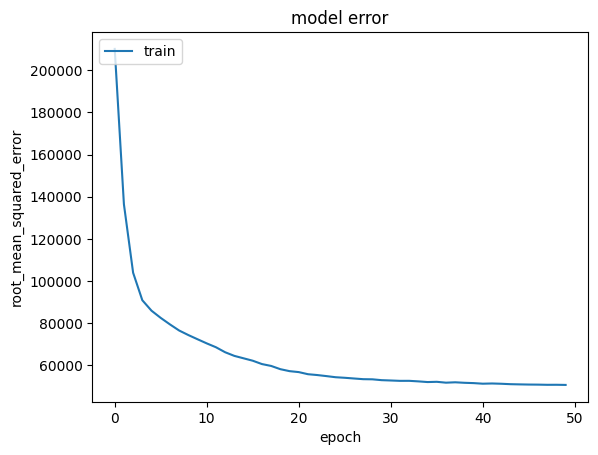

In [ ]:
plt.plot(hist.history['root_mean_squared_error'])
#plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('model error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

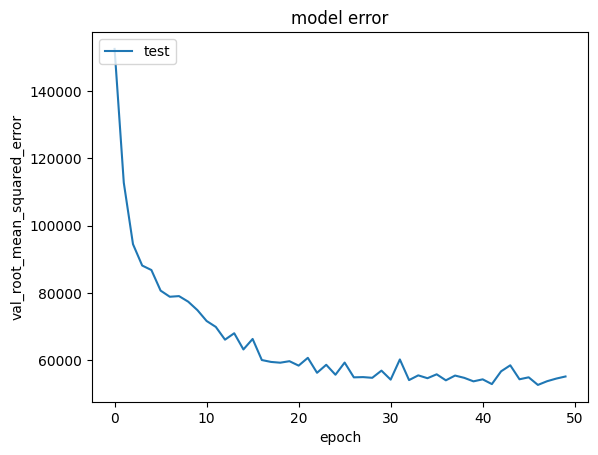

In [ ]:
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('model error')
plt.ylabel('val_root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

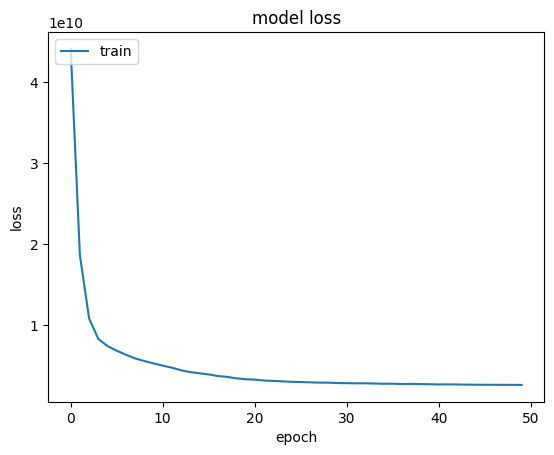

In [ ]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

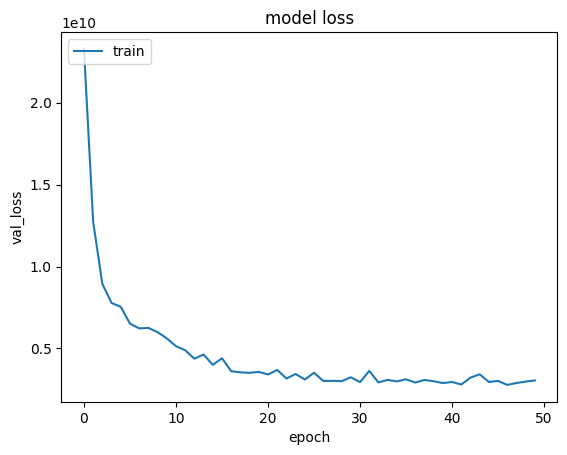

In [ ]:
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# **Qn 2**
e. Using the model from the best epoch, report the test R2 value and show the 4 top 30 test samples with the largest errors. List down any trends you find in
these samples and suggest ways to reduce these errors.

In [ ]:
#Defining new Function for the purpose of meeting the requirements of testing the models
def dataframe_to_dataset_test(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    labels =tf.cast(labels,tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

def dataframe_to_dataset_labels(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    labels =tf.cast(labels,tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [ ]:
#Creating the testing data set for predicting
val_ds_test = dataframe_to_dataset(val_dataframe)
val_ds_test = val_ds_test.batch(256)

In [ ]:
#Predicting the test data
y_pred = q2_model.predict(val_ds_test)

92/92 [==============================] - 1s 3ms/step


In [ ]:
# Predicted data
y_pred

array([[615555.1 ],
       [323953.25],
       [316824.5 ],
       ...,
       [285521.  ],
       [350669.97],
       [469721.5 ]], dtype=float32)

In [ ]:
y_pred = y_pred.reshape(-1)

In [ ]:
y_true = val_dataframe.pop("resale_price")

In [ ]:
y_true.values.reshape

array([265000., 470000., 230000., ..., 638000., 683500., 670000.])

In [ ]:
difference = y_true.values - y_pred

In [ ]:
sorted_index_array = np.argsort(difference)
sorted_array = difference[sorted_index_array]
rslt = sorted_array[-30 : ]

In [ ]:
#Top 30 error in the prediction compared to original data. (Descending order)
rslt

array([708281.75    , 708977.375   , 710962.25    , 718204.9375  ,
       725941.6875  , 734655.8125  , 737951.6875  , 737988.859375,
       745285.28125 , 745343.15625 , 749308.65625 , 755465.203125,
       757861.      , 760371.6875  , 774017.125   , 779128.875   ,
       789510.59375 , 795227.3125  , 798929.53125 , 806911.625   ,
       822917.78125 , 827669.1875  , 831054.0625  , 836198.875   ,
       843408.8125  , 848572.      , 853120.859375, 853540.5     ,
       927518.8125  , 965899.3125  ])

In [ ]:
#Craeting a New Dataset for the question 3
old_df = pd.read_csv('/content/drive/MyDrive/hdb_price_prediction_old.csv')
old_df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,710 YISHUN AVENUE 5,Yishun,0.826153,14.410089,0.016807,0.000382,"4 ROOM, New Generation",61.750000,93.0,07 TO 09,390000.0
104090,8,2021,117 YISHUN RING ROAD,Yishun,1.045337,15.215236,0.016807,0.000382,"4 ROOM, Model A",60.916667,104.0,07 TO 09,380000.0
104091,8,2021,453 YISHUN STREET 41,Khatib,1.424543,13.350952,0.016807,0.000968,"4 ROOM, Model A",91.083333,93.0,04 TO 06,433000.0
104092,8,2021,505D YISHUN STREET 51,Khatib,1.259536,13.232993,0.016807,0.000968,"4 ROOM, Model A",93.666667,93.0,01 TO 03,460000.0


In [ ]:
old_test_set = old_df[old_df['year']==2021]

In [ ]:
old_test_set = old_test_set[['dist_to_nearest_stn', 'dist_to_dhoby',  'degree_centrality', 'eigenvector_centrality',
                  'remaining_lease_years', 'floor_area_sqm', 'month', 'flat_model_type', 'storey_range', 'resale_price']]

In [ ]:
new_df = pd.read_csv('hdb_price_prediction.csv')
new_df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [ ]:
new_test_set = new_df[new_df['year'] >= 2021]

In [ ]:
new_test_set = new_test_set[['dist_to_nearest_stn', 'dist_to_dhoby',  'degree_centrality', 'eigenvector_centrality',
                  'remaining_lease_years', 'floor_area_sqm', 'month', 'flat_model_type', 'storey_range', 'resale_price']]

In [ ]:
#Defining new functions to avoid shuffle to generate similar result during testing
def dataframe_to_dataset_test_unshuffle(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    labels =tf.cast(labels,tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
    return ds

def dataframe_to_dataset_labels_unshuffle(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    return labels

In [ ]:
# Split data

old_test_set_ds = dataframe_to_dataset_test_unshuffle(old_test_set)
new_test_set_ds = dataframe_to_dataset_test_unshuffle(new_test_set)

old_test_set_ds_label = dataframe_to_dataset_labels_unshuffle(old_test_set)
new_test_set_ds_label = dataframe_to_dataset_labels_unshuffle(new_test_set)


old_test_set_ds = old_test_set_ds.batch(256)
new_test_set_ds = new_test_set_ds.batch(256)

# **Qn 3**
a.  Apply your model from Q2d on the ‘old test set’. On the ‘new test set’, split it into 2021 and 2022. For all 3 test sets, report the test R2 value you obtained.

In [ ]:
# Creating a new dataset for part a - requirement
new_test_set_1 = new_df[new_df['year'] == 2021]
new_test_set_2 = new_df[new_df['year'] == 2022]

In [ ]:
new_test_set_1 = new_test_set_1[['dist_to_nearest_stn', 'dist_to_dhoby',  'degree_centrality', 'eigenvector_centrality',
                  'remaining_lease_years', 'floor_area_sqm', 'month', 'flat_model_type', 'storey_range', 'resale_price']]
new_test_set_2 = new_test_set_2[['dist_to_nearest_stn', 'dist_to_dhoby',  'degree_centrality', 'eigenvector_centrality',
                  'remaining_lease_years', 'floor_area_sqm', 'month', 'flat_model_type', 'storey_range', 'resale_price']]

In [ ]:
new_test_set_1_ds = dataframe_to_dataset_test_unshuffle(new_test_set_1)
new_test_set_2_ds = dataframe_to_dataset_test_unshuffle(new_test_set_2)

new_test_set_1_ds_label = dataframe_to_dataset_labels_unshuffle(new_test_set_1)
new_test_set_2_ds_label = dataframe_to_dataset_labels_unshuffle(new_test_set_2)

new_test_set_1_ds = new_test_set_1_ds.batch(256)
new_test_set_2_ds = new_test_set_2_ds.batch(256)

In [ ]:
# Prediction for old test set
y_pred_old_test_set = q2_model.predict(old_test_set_ds)

66/66 [==============================] - 0s 3ms/step


In [ ]:
print(y_pred_old_test_set.reshape(-1), old_test_set_ds_label.values)

[216383.69 197839.6  297320.62 ... 371050.25 365698.72 447418.56] [225000. 211000. 275888. ... 433000. 460000. 550000.]


In [ ]:
# Prediction for new test set 1
y_pred_new_test_set_1 = q2_model.predict(new_test_set_1_ds)

114/114 [==============================] - 0s 3ms/step


In [ ]:
print(y_pred_new_test_set_1.reshape(-1), new_test_set_1_ds_label.values)

[216383.69 197839.6  297320.62 ... 535203.   621256.75 787533.25] [225000. 211000. 275888. ... 738000. 755000. 865000.]


In [ ]:
# Prediction for new test set 2
y_pred_new_test_set_2 = q2_model.predict(new_test_set_2_ds)

67/67 [==============================] - 0s 4ms/step


In [ ]:
print(y_pred_new_test_set_2.reshape(-1), new_test_set_2_ds_label.values)

[202891.33 213365.8  213078.72 ... 754326.75 766726.   730325.  ] [235000. 245000. 238888. ... 842000. 845000. 862000.]


In [ ]:
from sklearn.metrics import r2_score
#libraries for R2 score, was unable to use r2 previously defined as it required in tensor format

In [ ]:
print('Old Test Set R2 value:',r2_score(old_test_set_ds_label.values,y_pred_old_test_set))

Old Test Set R2 value: 0.7809368550283049


In [ ]:
print('New Test Set 1 R2 value:',r2_score(new_test_set_1_ds_label.values,y_pred_new_test_set_1))

New Test Set 1 R2 value: 0.7237848268761291


In [ ]:
print('New Test Set 2 R2 value:',r2_score(new_test_set_2_ds_label.values,y_pred_new_test_set_2))

New Test Set 2 R2 value: 0.4659062458533024


# **Qn 3**
b. In light of this (along with their result in Q1b and your results from Q3a), compare the extent to which model degradation has impacted your model to that of the team’s linear regression model and explain why this has occurred

There is significant model degradation that is happening as the R^2 value of the intial model in Q1b is 0.626 and using Sklearn it was 0.627, from that it has decreased to 0.465 for neural network and 0.464 for Sklearn. But as you can see the model degrdation has been the same for both the models.

Model Degradation mainly happens as a result of shift in trend i.e once the model is trained and deployed we are not retraining the model, so if there is slight shift in trend from the original training dataset the model performs poorly

# **Qn 3**
c.
With appropriate plots, visualise the distributions of all the features and labels used by the model. Which variable(s) showed the largest covariate/label shift that might have led to the drop in model performance as seen in Q3b?

In [ ]:
#Importing Libraries for better plots
import seaborn as sns

In [ ]:
sns.set_theme(style="darkgrid") # for better vizualization

In [ ]:
new_df_train = new_df[new_df['year'] < 2021] # new dataset for part c requirements

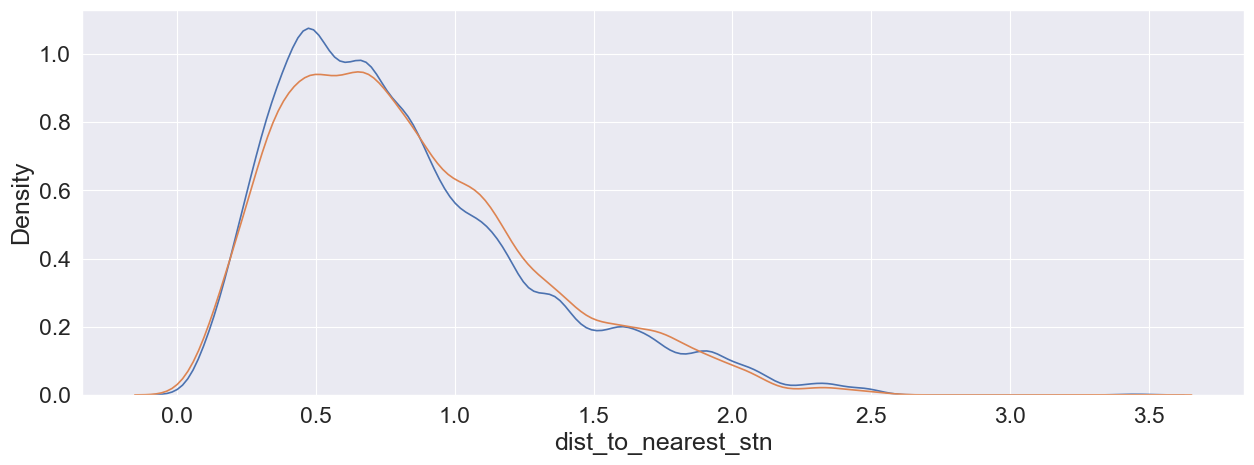

In [ ]:
# Creating a Kdeplot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.kdeplot(data=new_df_train , x='dist_to_nearest_stn', ax=ax)
sns.kdeplot(data=new_test_set_2 , x='dist_to_nearest_stn', ax=ax)
plt.show()

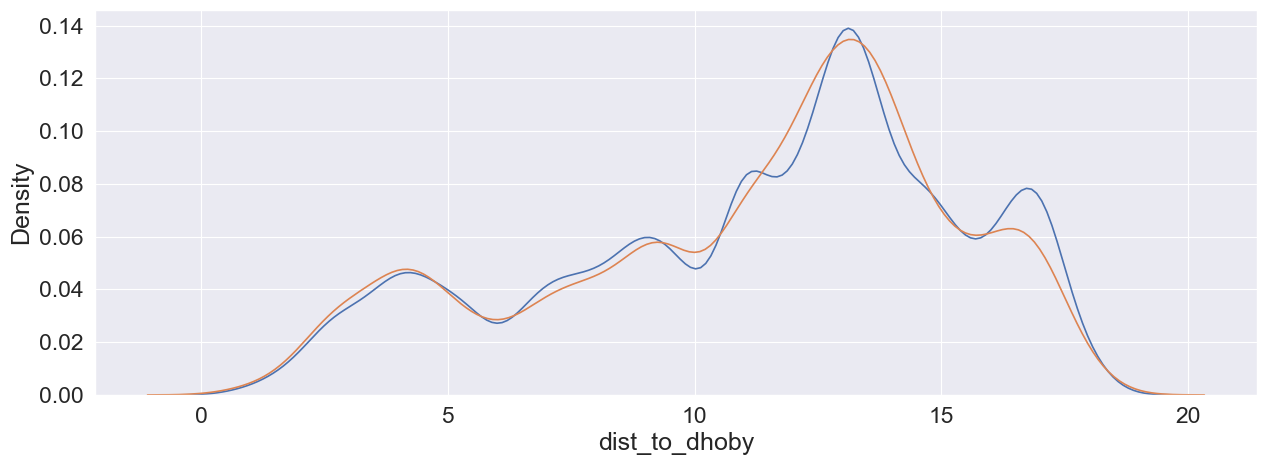

In [ ]:
# Creating a Kdeplot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.kdeplot(data=new_df_train , x='dist_to_dhoby', ax=ax)
sns.kdeplot(data=new_test_set_2 , x='dist_to_dhoby', ax=ax)
plt.show()

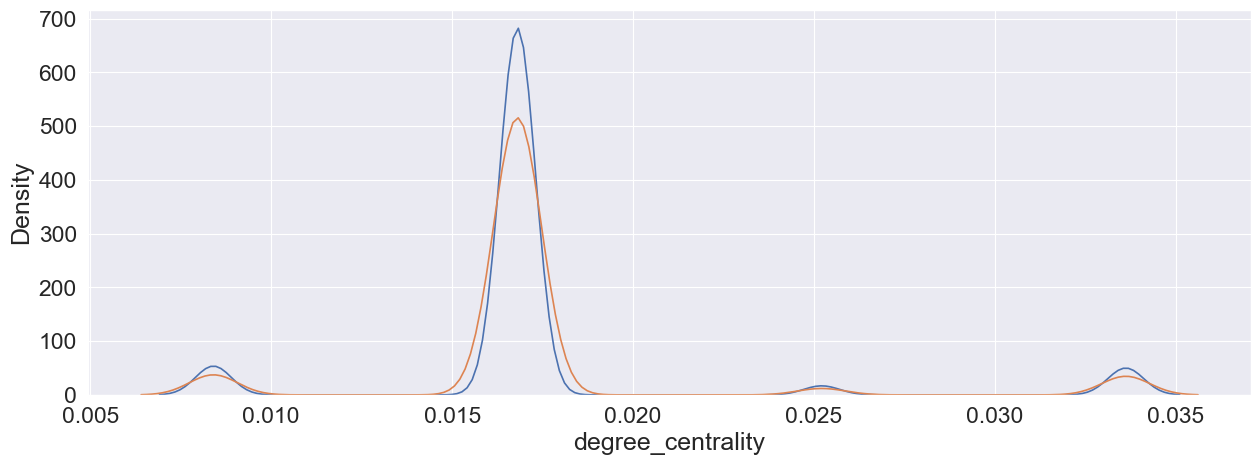

In [ ]:
# Creating a Kdeplot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.kdeplot(data=new_df_train , x='degree_centrality', ax=ax)
sns.kdeplot(data=new_test_set_2 , x='degree_centrality', ax=ax)
plt.show()

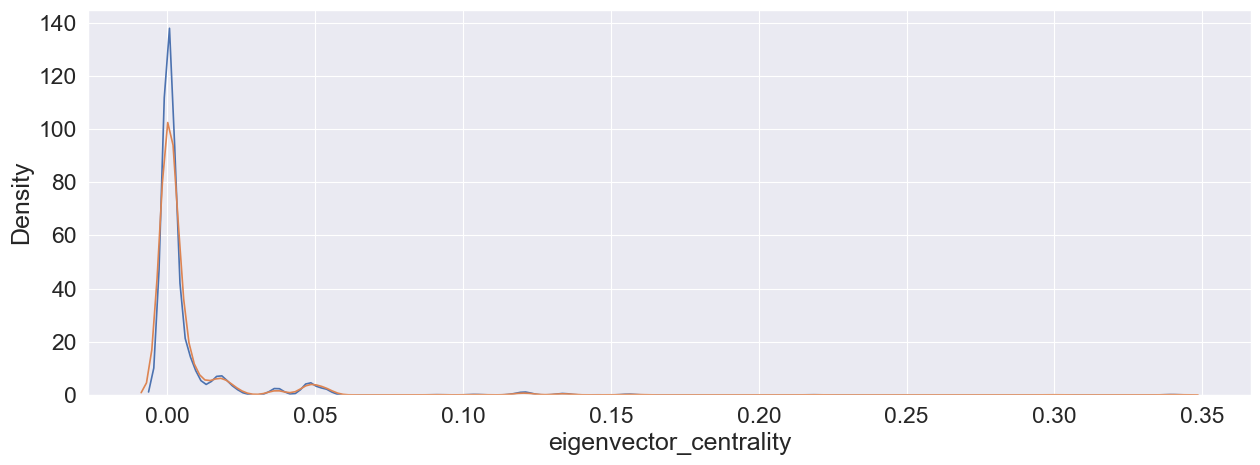

In [ ]:
# Creating a Kdeplot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.kdeplot(data=new_df_train , x='eigenvector_centrality', ax=ax)
sns.kdeplot(data=new_test_set_2 , x='eigenvector_centrality', ax=ax)
plt.show()

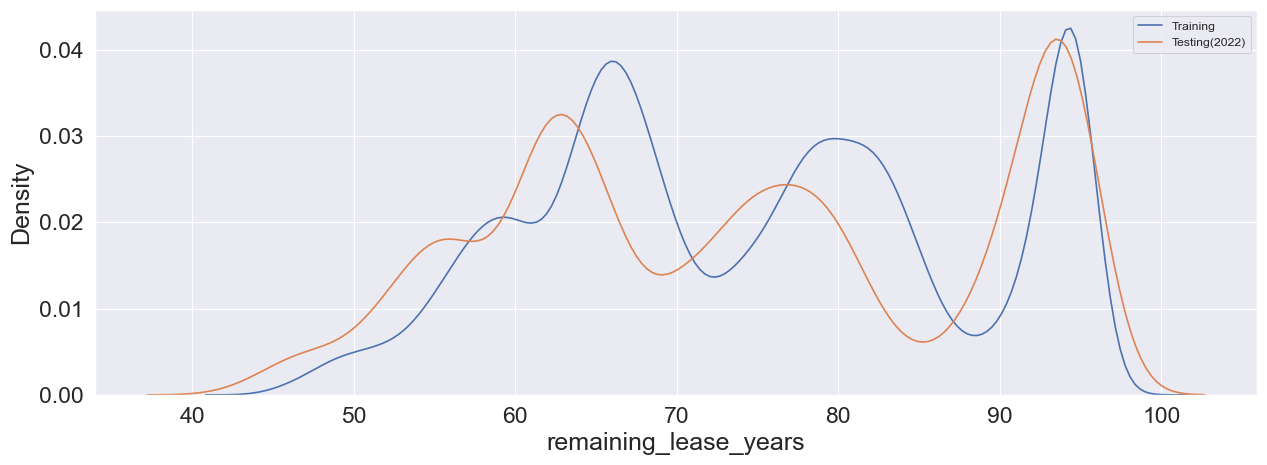

In [ ]:
# Creating a Kdeplot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.kdeplot(data=new_df_train , x='remaining_lease_years', ax=ax, label='Training')
sns.kdeplot(data=new_test_set_2 , x='remaining_lease_years', ax=ax, label='Testing(2022)')
ax.legend(loc="best")
plt.show()

#There is significant shift in the dataset of year training(<2021) and 2022
#Largest Shift in feature

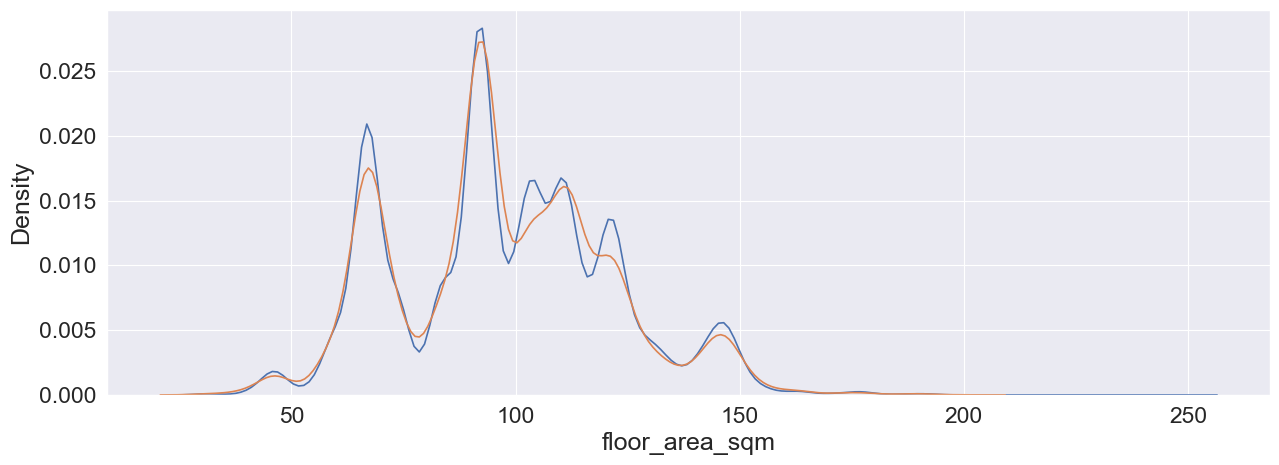

In [ ]:
# Creating a Kdeplot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.kdeplot(data=new_df_train , x='floor_area_sqm', ax=ax)
sns.kdeplot(data=new_test_set_2 , x='floor_area_sqm', ax=ax)
plt.show()

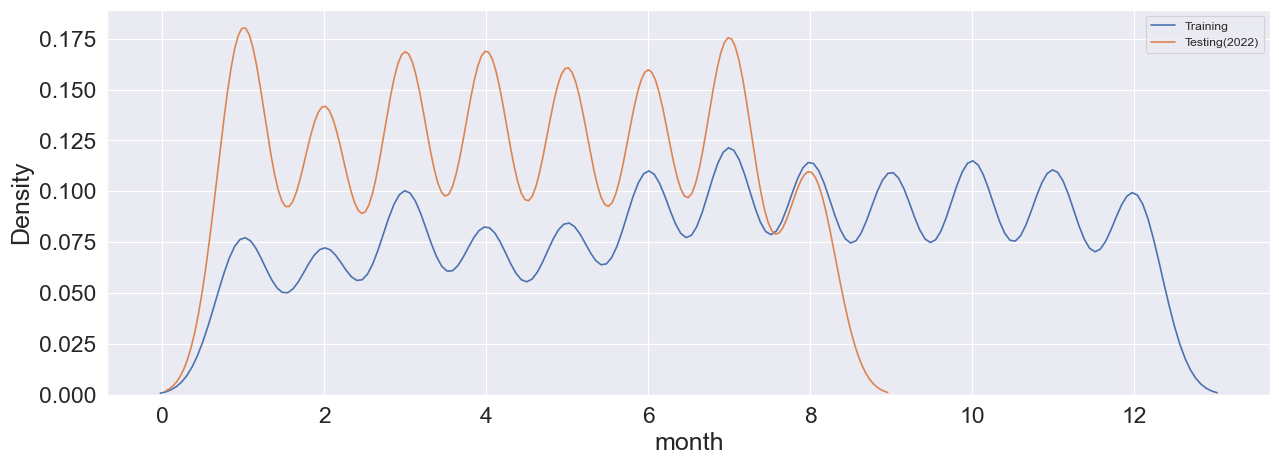

In [ ]:
# Creating a Histplot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.kdeplot(data=new_df_train , x='month', ax=ax, label='Training')
sns.kdeplot(data=new_test_set_2 , x='month', ax=ax, label='Testing(2022)')
ax.legend(loc="best")
plt.show()
#Lack of data after months 8

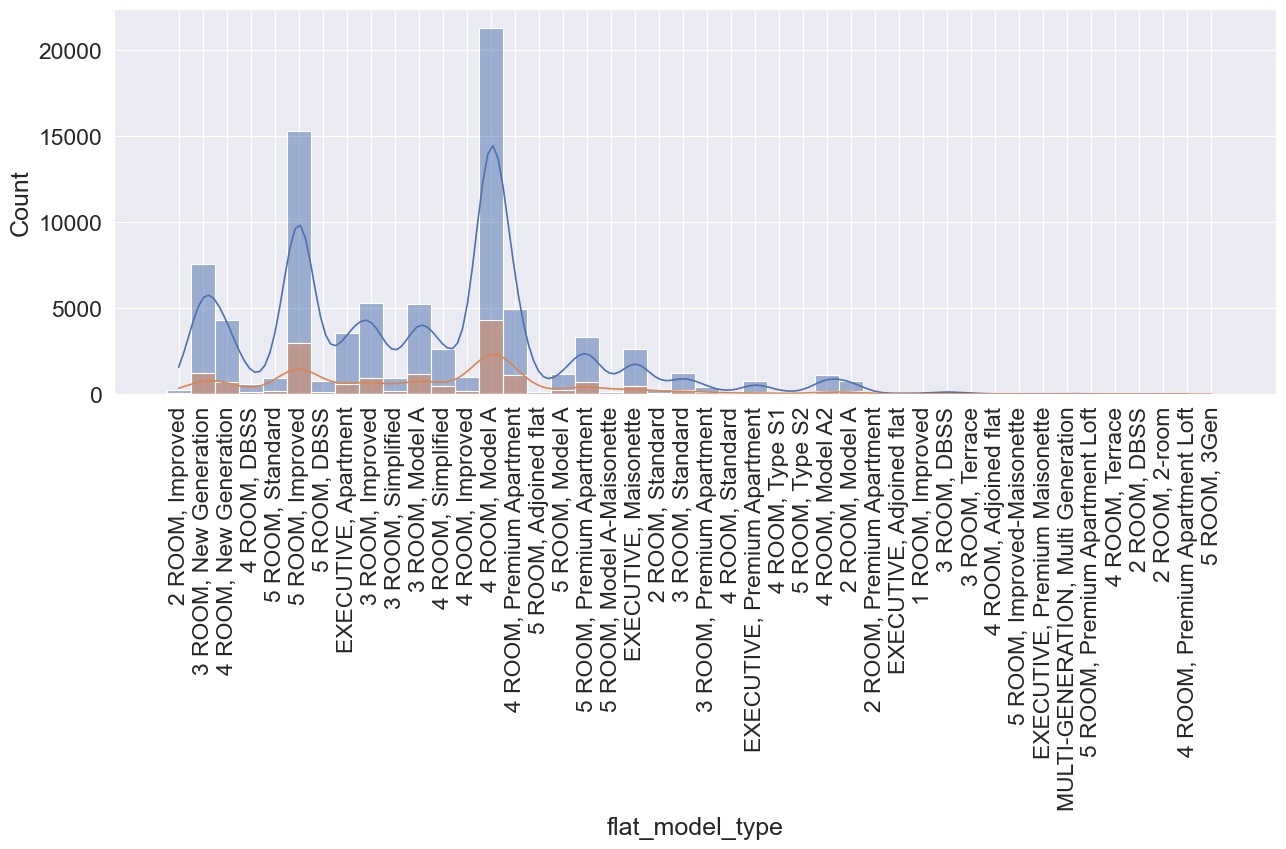

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.histplot(data=new_df_train , x='flat_model_type', ax=ax, kde=True)
sns.histplot(data=new_test_set_2 , x='flat_model_type', ax=ax, kde=True)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

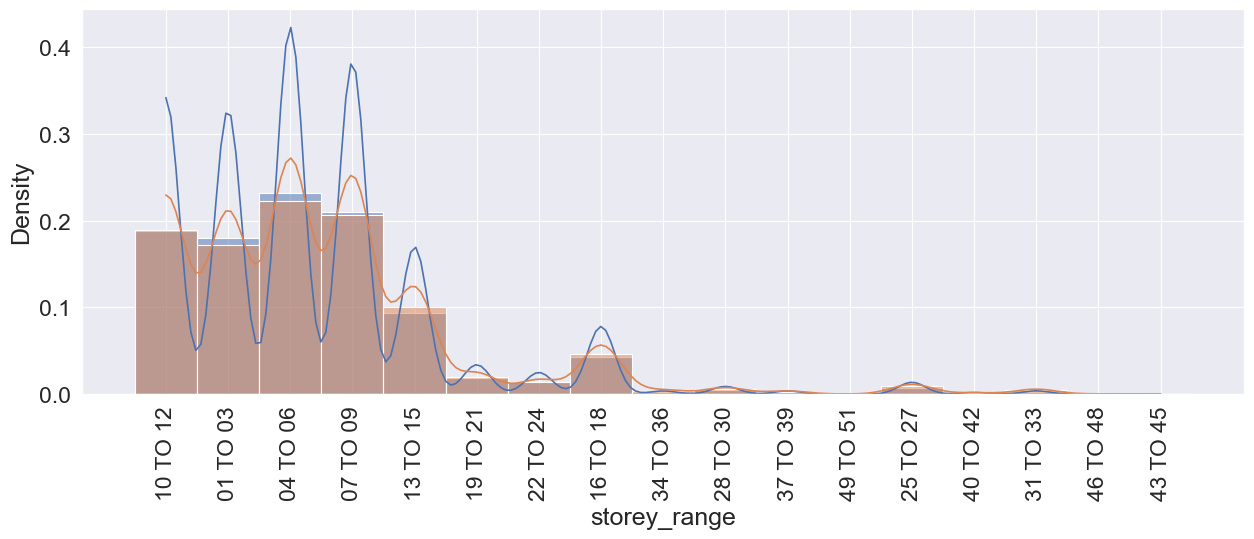

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.histplot(data=new_df_train , x='storey_range', ax=ax, kde=True, stat='density')
sns.histplot(data=new_test_set_2 , x='storey_range', ax=ax, kde=True, stat='density')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

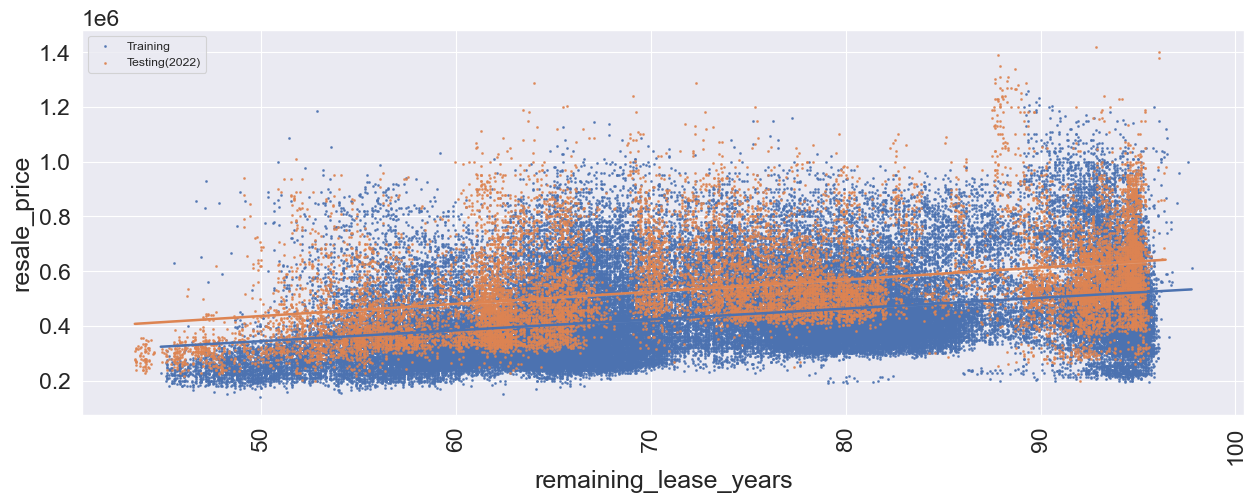

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.regplot(data=new_df_train , x='remaining_lease_years', y='resale_price', ax=ax, scatter_kws={'s':1}, label='Training')
sns.regplot(data=new_test_set_2 , x='remaining_lease_years', y='resale_price' , ax=ax, scatter_kws={'s':1}, label='Testing(2022)')
ax.legend(loc="best")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()
#It is Clearly Visible that the there is shift in Data, indicated by the shift in linear regression of Training and Testing

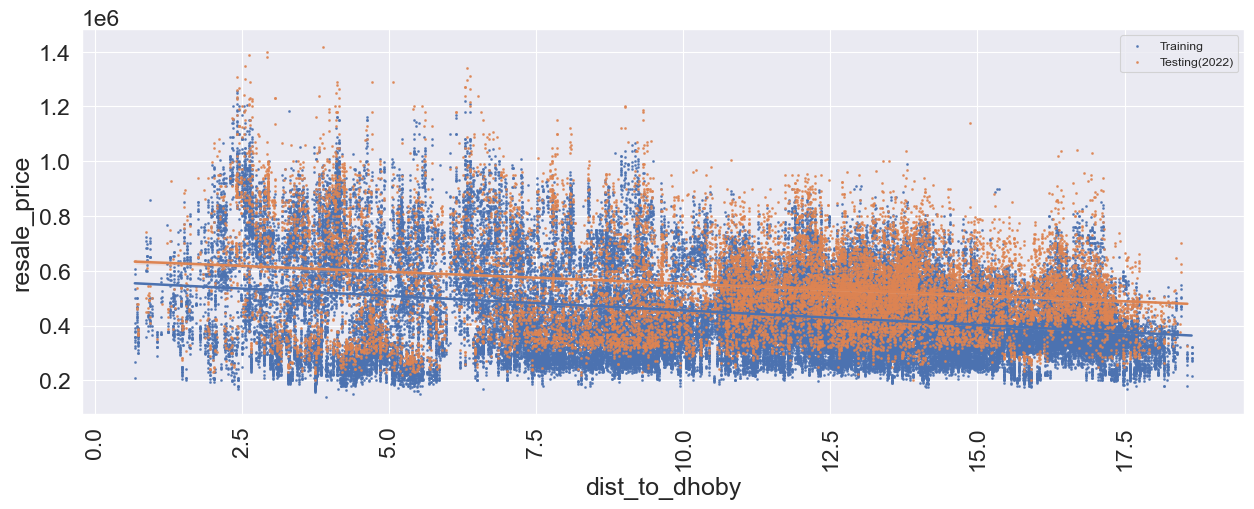

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.regplot(data=new_df_train , x='dist_to_dhoby', y='resale_price', ax=ax, scatter_kws={'s':1}, label='Training')
sns.regplot(data=new_test_set_2 , x='dist_to_dhoby', y='resale_price' , ax=ax, scatter_kws={'s':1}, label='Testing(2022)')
ax.legend(loc="best")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

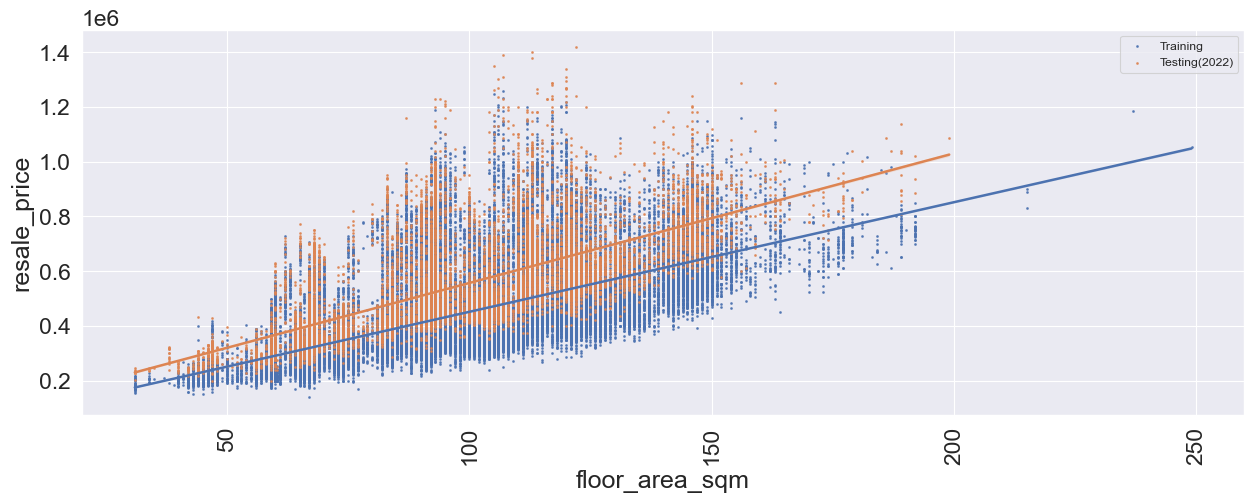

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.regplot(data=new_df_train , x='floor_area_sqm', y='resale_price', ax=ax, scatter_kws={'s':1}, label='Training')
sns.regplot(data=new_test_set_2 , x='floor_area_sqm', y='resale_price' , ax=ax, scatter_kws={'s':1}, label='Testing(2022)')
ax.legend(loc="best")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

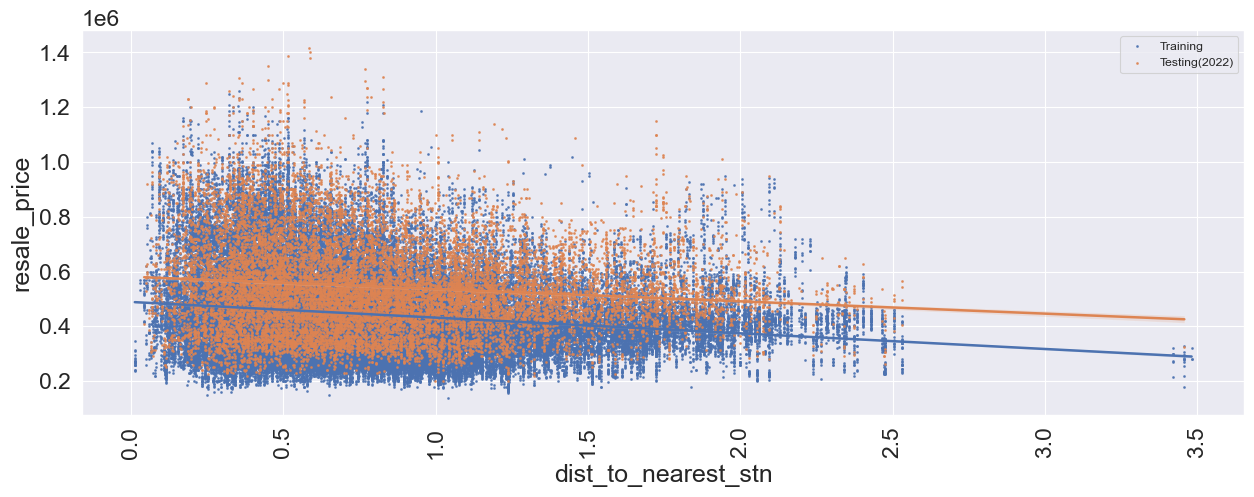

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.regplot(data=new_df_train , x='dist_to_nearest_stn', y='resale_price', ax=ax, scatter_kws={'s':1}, label='Training')
sns.regplot(data=new_test_set_2 , x='dist_to_nearest_stn', y='resale_price' , ax=ax, scatter_kws={'s':1}, label='Testing(2022)')
ax.legend(loc="best")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In general there is shift in the intercept for majority of the Features when comparing the Training and Testing(2022) data, This results in increased error by the model, which is shown in the form of reduced R2 score.

Feature selection also contributes to model degeradation as there could be less significant feature and features than could be more significant. If we remove the less significant features the model will be able to perform better on new test data therby avoiding model degradation.

# **Qn 3**
d. The team passed you a script (‘RFE.py’) that recursively removes features 2 from a neural network, so as to find the best feature subset. Run this piece of
code with your model from Q2d and report the best feature subset obtained.


In [ ]:
%run RFE

vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, de

251/251 [==============================] - 2s 8ms/step - loss: 3445643008.0000 - root_mean_squared_error: 58699.6016 - val_loss: 3626797824.0000 - val_root_mean_squared_error: 60222.9023
Epoch 20/50
251/251 [==============================] - 2s 7ms/step - loss: 3321837312.0000 - root_mean_squared_error: 57635.3828 - val_loss: 3895850496.0000 - val_root_mean_squared_error: 62416.7500
Epoch 21/50
251/251 [==============================] - 2s 7ms/step - loss: 3241091328.0000 - root_mean_squared_error: 56930.5820 - val_loss: 3409154560.0000 - val_root_mean_squared_error: 58387.9648
Epoch 22/50
251/251 [==============================] - 2s 7ms/step - loss: 3159799040.0000 - root_mean_squared_error: 56212.0898 - val_loss: 3382685696.0000 - val_root_mean_squared_error: 58160.8594
Epoch 23/50
251/251 [==============================] - 2s 7ms/step - loss: 3109337088.0000 - root_mean_squared_error: 55761.4297 - val_loss: 3189829632.0000 - val_root_mean_squared_error: 56478.5781
Epoch 24/50
251/2

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
going through feature_mask [1, 0, 1, 1, 1, 1, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 156), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1848), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created 

251/251 [==============================] - 1s 5ms/step - loss: 3115751680.0000 - root_mean_squared_error: 55818.9180 - val_loss: 3524303104.0000 - val_root_mean_squared_error: 59365.8398
Epoch 30/50
251/251 [==============================] - 1s 5ms/step - loss: 3117740288.0000 - root_mean_squared_error: 55836.7305 - val_loss: 3716969472.0000 - val_root_mean_squared_error: 60966.9531
Epoch 31/50
251/251 [==============================] - 1s 4ms/step - loss: 3114730496.0000 - root_mean_squared_error: 55809.7695 - val_loss: 3976220672.0000 - val_root_mean_squared_error: 63057.2812
Epoch 32/50
251/251 [==============================] - 1s 5ms/step - loss: 3081661696.0000 - root_mean_squared_error: 55512.7148 - val_loss: 3727683840.0000 - val_root_mean_squared_error: 61054.7617
Epoch 33/50
251/251 [==============================] - 1s 4ms/step - loss: 3068546304.0000 - root_mean_squared_error: 55394.4609 - val_loss: 4226988288.0000 - val_root_mean_squared_error: 65015.2930
Epoch 34/50
251/2

251/251 [==============================] - 3s 8ms/step - loss: 43699056640.0000 - root_mean_squared_error: 209043.1875 - val_loss: 22415994880.0000 - val_root_mean_squared_error: 149719.7188
Epoch 2/50
251/251 [==============================] - 2s 7ms/step - loss: 17788577792.0000 - root_mean_squared_error: 133373.8281 - val_loss: 12611636224.0000 - val_root_mean_squared_error: 112301.5391
Epoch 3/50
251/251 [==============================] - 2s 7ms/step - loss: 11128008704.0000 - root_mean_squared_error: 105489.3750 - val_loss: 10020075520.0000 - val_root_mean_squared_error: 100100.3281
Epoch 4/50
251/251 [==============================] - 2s 8ms/step - loss: 9567267840.0000 - root_mean_squared_error: 97812.4141 - val_loss: 9110495232.0000 - val_root_mean_squared_error: 95448.9141
Epoch 5/50
251/251 [==============================] - 2s 7ms/step - loss: 8748397568.0000 - root_mean_squared_error: 93532.8672 - val_loss: 8481897984.0000 - val_root_mean_squared_error: 92097.2188
Epoch 6/5

251/251 [==============================] - 2s 7ms/step - loss: 3212566272.0000 - root_mean_squared_error: 56679.5039 - val_loss: 3641680384.0000 - val_root_mean_squared_error: 60346.3359
Epoch 43/50
251/251 [==============================] - 2s 7ms/step - loss: 3184986880.0000 - root_mean_squared_error: 56435.6875 - val_loss: 3702005760.0000 - val_root_mean_squared_error: 60844.1094
Epoch 44/50
251/251 [==============================] - 2s 7ms/step - loss: 3178903040.0000 - root_mean_squared_error: 56381.7617 - val_loss: 3590350592.0000 - val_root_mean_squared_error: 59919.5352
Epoch 45/50
251/251 [==============================] - 2s 7ms/step - loss: 3178804736.0000 - root_mean_squared_error: 56380.8906 - val_loss: 3530182400.0000 - val_root_mean_squared_error: 59415.3398
Epoch 46/50
251/251 [==============================] - 2s 7ms/step - loss: 3156430848.0000 - root_mean_squared_error: 56182.1211 - val_loss: 3663972096.0000 - val_root_mean_squared_error: 60530.7539
Epoch 47/50
251/2

251/251 [==============================] - 2s 8ms/step - loss: 6023348736.0000 - root_mean_squared_error: 77610.2344 - val_loss: 5902963200.0000 - val_root_mean_squared_error: 76830.7422
Epoch 11/50
251/251 [==============================] - 2s 8ms/step - loss: 5768369664.0000 - root_mean_squared_error: 75949.7812 - val_loss: 5703278080.0000 - val_root_mean_squared_error: 75520.0547
Epoch 12/50
251/251 [==============================] - 2s 8ms/step - loss: 5567141888.0000 - root_mean_squared_error: 74613.2812 - val_loss: 5725108736.0000 - val_root_mean_squared_error: 75664.4453
Epoch 13/50
251/251 [==============================] - 2s 8ms/step - loss: 5381862400.0000 - root_mean_squared_error: 73361.1797 - val_loss: 5668999680.0000 - val_root_mean_squared_error: 75292.7578
Epoch 14/50
251/251 [==============================] - 2s 8ms/step - loss: 5239081984.0000 - root_mean_squared_error: 72381.5000 - val_loss: 5794696704.0000 - val_root_mean_squared_error: 76122.9062
Epoch 15/50
251/2

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this 

Epoch 20/50
251/251 [==============================] - 2s 8ms/step - loss: 6529228800.0000 - root_mean_squared_error: 80803.6406 - val_loss: 7006798336.0000 - val_root_mean_squared_error: 83706.6172
Epoch 21/50
251/251 [==============================] - 2s 8ms/step - loss: 6494429696.0000 - root_mean_squared_error: 80588.0234 - val_loss: 6275579904.0000 - val_root_mean_squared_error: 79218.5547
Epoch 22/50
251/251 [==============================] - 2s 8ms/step - loss: 6405756928.0000 - root_mean_squared_error: 80035.9766 - val_loss: 6293180416.0000 - val_root_mean_squared_error: 79329.5703
Epoch 23/50
251/251 [==============================] - 2s 8ms/step - loss: 6396960256.0000 - root_mean_squared_error: 79981.0000 - val_loss: 6418937856.0000 - val_root_mean_squared_error: 80118.2734
Epoch 24/50
251/251 [==============================] - 2s 8ms/step - loss: 6276063744.0000 - root_mean_squared_error: 79221.6094 - val_loss: 6139275264.0000 - val_root_mean_squared_error: 78353.5312
Epoch

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
going through feature_mask [1, 1, 1, 1, 1, 0, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 156), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1848), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created by layer 

Epoch 30/50
251/251 [==============================] - 2s 8ms/step - loss: 3036730880.0000 - root_mean_squared_error: 55106.5430 - val_loss: 3186510336.0000 - val_root_mean_squared_error: 56449.1836
Epoch 31/50
251/251 [==============================] - 2s 8ms/step - loss: 2998528768.0000 - root_mean_squared_error: 54758.8242 - val_loss: 3423255552.0000 - val_root_mean_squared_error: 58508.5938
Epoch 32/50
251/251 [==============================] - 2s 8ms/step - loss: 3012530176.0000 - root_mean_squared_error: 54886.5195 - val_loss: 3561964544.0000 - val_root_mean_squared_error: 59682.1953
Epoch 33/50
251/251 [==============================] - 2s 8ms/step - loss: 2988643328.0000 - root_mean_squared_error: 54668.4844 - val_loss: 3684693760.0000 - val_root_mean_squared_error: 60701.6797
Epoch 34/50
251/251 [==============================] - 2s 8ms/step - loss: 2974018560.0000 - root_mean_squared_error: 54534.5625 - val_loss: 3049649152.0000 - val_root_mean_squared_error: 55223.6289
Epoch

251/251 [==============================] - 3s 9ms/step - loss: 43695702016.0000 - root_mean_squared_error: 209035.1719 - val_loss: 23665997824.0000 - val_root_mean_squared_error: 153837.5625
Epoch 2/50
251/251 [==============================] - 2s 8ms/step - loss: 20642111488.0000 - root_mean_squared_error: 143673.6250 - val_loss: 13962743808.0000 - val_root_mean_squared_error: 118164.0547
Epoch 3/50
251/251 [==============================] - 2s 8ms/step - loss: 11088614400.0000 - root_mean_squared_error: 105302.4922 - val_loss: 9102792704.0000 - val_root_mean_squared_error: 95408.5547
Epoch 4/50
251/251 [==============================] - 2s 9ms/step - loss: 8591507456.0000 - root_mean_squared_error: 92690.3828 - val_loss: 8084217856.0000 - val_root_mean_squared_error: 89912.2812
Epoch 5/50
251/251 [==============================] - 2s 8ms/step - loss: 7782207488.0000 - root_mean_squared_error: 88216.8203 - val_loss: 7529971200.0000 - val_root_mean_squared_error: 86775.4062
Epoch 6/50


251/251 [==============================] - 2s 8ms/step - loss: 2669990656.0000 - root_mean_squared_error: 51671.9531 - val_loss: 3009926912.0000 - val_root_mean_squared_error: 54862.8008
Epoch 43/50
251/251 [==============================] - 2s 8ms/step - loss: 2635754240.0000 - root_mean_squared_error: 51339.5977 - val_loss: 3127737856.0000 - val_root_mean_squared_error: 55926.1836
Epoch 44/50
251/251 [==============================] - 2s 8ms/step - loss: 2632792576.0000 - root_mean_squared_error: 51310.7461 - val_loss: 3063113472.0000 - val_root_mean_squared_error: 55345.4023
Epoch 45/50
251/251 [==============================] - 2s 8ms/step - loss: 2609724928.0000 - root_mean_squared_error: 51085.4688 - val_loss: 2881025536.0000 - val_root_mean_squared_error: 53675.1836
Epoch 46/50
251/251 [==============================] - 2s 8ms/step - loss: 2617999104.0000 - root_mean_squared_error: 51166.3867 - val_loss: 2953808640.0000 - val_root_mean_squared_error: 54348.9531
Epoch 47/50
251/2

251/251 [==============================] - 2s 8ms/step - loss: 5472890368.0000 - root_mean_squared_error: 73978.9844 - val_loss: 5814688768.0000 - val_root_mean_squared_error: 76254.1094
Epoch 11/50
251/251 [==============================] - 2s 8ms/step - loss: 5274101760.0000 - root_mean_squared_error: 72623.0078 - val_loss: 5552764416.0000 - val_root_mean_squared_error: 74516.8750
Epoch 12/50
251/251 [==============================] - 2s 8ms/step - loss: 5058579456.0000 - root_mean_squared_error: 71123.6875 - val_loss: 5165879808.0000 - val_root_mean_squared_error: 71874.0547
Epoch 13/50
251/251 [==============================] - 2s 8ms/step - loss: 4780227072.0000 - root_mean_squared_error: 69139.1875 - val_loss: 5183848448.0000 - val_root_mean_squared_error: 71998.9453
Epoch 14/50
251/251 [==============================] - 2s 8ms/step - loss: 4550605312.0000 - root_mean_squared_error: 67458.1719 - val_loss: 5182383616.0000 - val_root_mean_squared_error: 71988.7734
Epoch 15/50
251/2

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this 

Epoch 20/50
251/251 [==============================] - 2s 8ms/step - loss: 3467938304.0000 - root_mean_squared_error: 58889.2031 - val_loss: 3803573504.0000 - val_root_mean_squared_error: 61673.1172
Epoch 21/50
251/251 [==============================] - 2s 8ms/step - loss: 3415328768.0000 - root_mean_squared_error: 58440.8125 - val_loss: 3517284352.0000 - val_root_mean_squared_error: 59306.6992
Epoch 22/50
251/251 [==============================] - 2s 8ms/step - loss: 3391763712.0000 - root_mean_squared_error: 58238.8516 - val_loss: 3779683072.0000 - val_root_mean_squared_error: 61479.1289
Epoch 23/50
251/251 [==============================] - 2s 8ms/step - loss: 3341668864.0000 - root_mean_squared_error: 57807.1680 - val_loss: 3633250560.0000 - val_root_mean_squared_error: 60276.4492
Epoch 24/50
251/251 [==============================] - 2s 8ms/step - loss: 3292646912.0000 - root_mean_squared_error: 57381.5898 - val_loss: 3486789120.0000 - val_root_mean_squared_error: 59049.0391
Epoch

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
going through feature_mask [0, 1, 1, 1, 1, 1, 0, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 156), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1848), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created 

251/251 [==============================] - 2s 7ms/step - loss: 2826707200.0000 - root_mean_squared_error: 53166.7852 - val_loss: 3285340160.0000 - val_root_mean_squared_error: 57317.8867
Epoch 30/50
251/251 [==============================] - 2s 8ms/step - loss: 2805398784.0000 - root_mean_squared_error: 52966.0156 - val_loss: 3104725248.0000 - val_root_mean_squared_error: 55720.0625
Epoch 31/50
251/251 [==============================] - 2s 8ms/step - loss: 2791014912.0000 - root_mean_squared_error: 52830.0586 - val_loss: 2982161152.0000 - val_root_mean_squared_error: 54609.1680
Epoch 32/50
251/251 [==============================] - 2s 7ms/step - loss: 2797069056.0000 - root_mean_squared_error: 52887.3242 - val_loss: 3209338368.0000 - val_root_mean_squared_error: 56651.0234
Epoch 33/50
251/251 [==============================] - 2s 8ms/step - loss: 2762752768.0000 - root_mean_squared_error: 52561.8945 - val_loss: 3558630912.0000 - val_root_mean_squared_error: 59654.2617
Epoch 34/50
251/2

251/251 [==============================] - 2s 5ms/step - loss: 52712243200.0000 - root_mean_squared_error: 229591.4688 - val_loss: 23377758208.0000 - val_root_mean_squared_error: 152897.8750
Epoch 2/50
251/251 [==============================] - 1s 5ms/step - loss: 22681419776.0000 - root_mean_squared_error: 150603.5156 - val_loss: 22978611200.0000 - val_root_mean_squared_error: 151586.9688
Epoch 3/50
251/251 [==============================] - 1s 5ms/step - loss: 21831604224.0000 - root_mean_squared_error: 147755.2188 - val_loss: 21648074752.0000 - val_root_mean_squared_error: 147132.8438
Epoch 4/50
251/251 [==============================] - 1s 5ms/step - loss: 19492130816.0000 - root_mean_squared_error: 139614.2188 - val_loss: 17838850048.0000 - val_root_mean_squared_error: 133562.1562
Epoch 5/50
251/251 [==============================] - 1s 5ms/step - loss: 15875819520.0000 - root_mean_squared_error: 125999.2812 - val_loss: 15641352192.0000 - val_root_mean_squared_error: 125065.3906
E

251/251 [==============================] - 1s 5ms/step - loss: 2962355968.0000 - root_mean_squared_error: 54427.5312 - val_loss: 4074491392.0000 - val_root_mean_squared_error: 63831.7422
Epoch 43/50
251/251 [==============================] - 1s 5ms/step - loss: 2932897280.0000 - root_mean_squared_error: 54156.2305 - val_loss: 3743678464.0000 - val_root_mean_squared_error: 61185.6055
Epoch 44/50
251/251 [==============================] - 1s 5ms/step - loss: 2917600768.0000 - root_mean_squared_error: 54014.8203 - val_loss: 3414375424.0000 - val_root_mean_squared_error: 58432.6562
Epoch 45/50
251/251 [==============================] - 1s 5ms/step - loss: 2915665152.0000 - root_mean_squared_error: 53996.8984 - val_loss: 3347390720.0000 - val_root_mean_squared_error: 57856.6406
Epoch 46/50
251/251 [==============================] - 1s 5ms/step - loss: 2902936064.0000 - root_mean_squared_error: 53878.9023 - val_loss: 3558303488.0000 - val_root_mean_squared_error: 59651.5156
Epoch 47/50
251/2

251/251 [==============================] - 2s 7ms/step - loss: 6082522112.0000 - root_mean_squared_error: 77990.5234 - val_loss: 6029044224.0000 - val_root_mean_squared_error: 77646.9219
Epoch 11/50
251/251 [==============================] - 2s 7ms/step - loss: 5692002816.0000 - root_mean_squared_error: 75445.3594 - val_loss: 5555796480.0000 - val_root_mean_squared_error: 74537.2188
Epoch 12/50
251/251 [==============================] - 2s 8ms/step - loss: 5285190144.0000 - root_mean_squared_error: 72699.3125 - val_loss: 5249940480.0000 - val_root_mean_squared_error: 72456.4766
Epoch 13/50
251/251 [==============================] - 2s 7ms/step - loss: 4857640448.0000 - root_mean_squared_error: 69696.7734 - val_loss: 4864616448.0000 - val_root_mean_squared_error: 69746.8047
Epoch 14/50
251/251 [==============================] - 2s 7ms/step - loss: 4500118016.0000 - root_mean_squared_error: 67082.9219 - val_loss: 4553384960.0000 - val_root_mean_squared_error: 67478.7734
Epoch 15/50
251/2

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this 

Epoch 20/50
251/251 [==============================] - 2s 9ms/step - loss: 4299261440.0000 - root_mean_squared_error: 65568.7500 - val_loss: 4458567168.0000 - val_root_mean_squared_error: 66772.5000
Epoch 21/50
251/251 [==============================] - 2s 8ms/step - loss: 4291738880.0000 - root_mean_squared_error: 65511.3633 - val_loss: 4773575168.0000 - val_root_mean_squared_error: 69091.0625
Epoch 22/50
251/251 [==============================] - 2s 8ms/step - loss: 4208259072.0000 - root_mean_squared_error: 64871.0977 - val_loss: 4916761088.0000 - val_root_mean_squared_error: 70119.6172
Epoch 23/50
251/251 [==============================] - 2s 8ms/step - loss: 4170299648.0000 - root_mean_squared_error: 64577.8555 - val_loss: 4248791296.0000 - val_root_mean_squared_error: 65182.7539
Epoch 24/50
251/251 [==============================] - 2s 8ms/step - loss: 4116510720.0000 - root_mean_squared_error: 64160.0391 - val_loss: 4438522368.0000 - val_root_mean_squared_error: 66622.2344
Epoch

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
going through feature_mask [1, 1, 1, 1, 0, 1, 0, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 156), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1848), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created by layer 

251/251 [==============================] - 2s 8ms/step - loss: 6801790464.0000 - root_mean_squared_error: 82472.9688 - val_loss: 6702906368.0000 - val_root_mean_squared_error: 81871.2812
Epoch 30/50
251/251 [==============================] - 2s 8ms/step - loss: 6754234880.0000 - root_mean_squared_error: 82184.1484 - val_loss: 6612682240.0000 - val_root_mean_squared_error: 81318.3984
Epoch 31/50
251/251 [==============================] - 2s 8ms/step - loss: 6749816320.0000 - root_mean_squared_error: 82157.2656 - val_loss: 7086093312.0000 - val_root_mean_squared_error: 84178.9375
Epoch 32/50
251/251 [==============================] - 2s 8ms/step - loss: 6665650176.0000 - root_mean_squared_error: 81643.4297 - val_loss: 7020992000.0000 - val_root_mean_squared_error: 83791.3594
Epoch 33/50
251/251 [==============================] - 2s 8ms/step - loss: 6603177472.0000 - root_mean_squared_error: 81259.9375 - val_loss: 6558090240.0000 - val_root_mean_squared_error: 80982.0391
Epoch 34/50
251/2

251/251 [==============================] - 3s 9ms/step - loss: 44092878848.0000 - root_mean_squared_error: 209983.0469 - val_loss: 23523766272.0000 - val_root_mean_squared_error: 153374.5938
Epoch 2/50
251/251 [==============================] - 2s 8ms/step - loss: 18960011264.0000 - root_mean_squared_error: 137695.3594 - val_loss: 12931927040.0000 - val_root_mean_squared_error: 113718.6328
Epoch 3/50
251/251 [==============================] - 2s 8ms/step - loss: 10993724416.0000 - root_mean_squared_error: 104850.9609 - val_loss: 9219152896.0000 - val_root_mean_squared_error: 96016.4219
Epoch 4/50
251/251 [==============================] - 2s 8ms/step - loss: 8656164864.0000 - root_mean_squared_error: 93038.5156 - val_loss: 8705294336.0000 - val_root_mean_squared_error: 93302.1641
Epoch 5/50
251/251 [==============================] - 2s 8ms/step - loss: 7943601664.0000 - root_mean_squared_error: 89126.8828 - val_loss: 7887850496.0000 - val_root_mean_squared_error: 88813.5703
Epoch 6/50


251/251 [==============================] - 2s 8ms/step - loss: 2874061568.0000 - root_mean_squared_error: 53610.2734 - val_loss: 3022696960.0000 - val_root_mean_squared_error: 54979.0586
Epoch 43/50
251/251 [==============================] - 2s 8ms/step - loss: 2836373504.0000 - root_mean_squared_error: 53257.6133 - val_loss: 3007361024.0000 - val_root_mean_squared_error: 54839.4102
Epoch 44/50
251/251 [==============================] - 2s 8ms/step - loss: 2809872128.0000 - root_mean_squared_error: 53008.2266 - val_loss: 3442998784.0000 - val_root_mean_squared_error: 58677.0703
Epoch 45/50
251/251 [==============================] - 2s 8ms/step - loss: 2848738048.0000 - root_mean_squared_error: 53373.5703 - val_loss: 2965506048.0000 - val_root_mean_squared_error: 54456.4609
Epoch 46/50
251/251 [==============================] - 2s 8ms/step - loss: 2796904704.0000 - root_mean_squared_error: 52885.7695 - val_loss: 3083342080.0000 - val_root_mean_squared_error: 55527.8477
Epoch 47/50
251/2

251/251 [==============================] - 2s 8ms/step - loss: 5332863488.0000 - root_mean_squared_error: 73026.4609 - val_loss: 5560523264.0000 - val_root_mean_squared_error: 74568.9141
Epoch 11/50
251/251 [==============================] - 2s 8ms/step - loss: 5076541440.0000 - root_mean_squared_error: 71249.8516 - val_loss: 6121833472.0000 - val_root_mean_squared_error: 78242.1484
Epoch 12/50
251/251 [==============================] - 2s 8ms/step - loss: 4749072896.0000 - root_mean_squared_error: 68913.5156 - val_loss: 5050702336.0000 - val_root_mean_squared_error: 71068.2969
Epoch 13/50
251/251 [==============================] - 2s 8ms/step - loss: 4456503296.0000 - root_mean_squared_error: 66757.0469 - val_loss: 5046767616.0000 - val_root_mean_squared_error: 71040.6016
Epoch 14/50
251/251 [==============================] - 2s 8ms/step - loss: 4174332928.0000 - root_mean_squared_error: 64609.0781 - val_loss: 4591609344.0000 - val_root_mean_squared_error: 67761.4141
Epoch 15/50
251/2

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this 

Epoch 20/50
251/251 [==============================] - 2s 8ms/step - loss: 3334144768.0000 - root_mean_squared_error: 57742.0547 - val_loss: 3515495936.0000 - val_root_mean_squared_error: 59291.6172
Epoch 21/50
251/251 [==============================] - 2s 8ms/step - loss: 3316051968.0000 - root_mean_squared_error: 57585.1719 - val_loss: 3624388608.0000 - val_root_mean_squared_error: 60202.8945
Epoch 22/50
251/251 [==============================] - 2s 8ms/step - loss: 3291813888.0000 - root_mean_squared_error: 57374.3320 - val_loss: 3616856576.0000 - val_root_mean_squared_error: 60140.3086
Epoch 23/50
251/251 [==============================] - 2s 8ms/step - loss: 3274076416.0000 - root_mean_squared_error: 57219.5469 - val_loss: 3325992960.0000 - val_root_mean_squared_error: 57671.4219
Epoch 24/50
251/251 [==============================] - 2s 8ms/step - loss: 3252632576.0000 - root_mean_squared_error: 57031.8555 - val_loss: 3435928320.0000 - val_root_mean_squared_error: 58616.7930
Epoch

In [ ]:
vec #Best feature Subset Obtained
#So eliminiated Feature eigenvector_centrality
# This might change for Each run

[1, 1, 1, 1, 1, 1, 0, 1, 1]

Final Output Reviced - [52998.65625, 56539.4375, 58515.94921875, 59919.23828125, 75327.6171875, 54313.859375, 52262.8046875, 64286.40625, 56762.171875]

# **Qn 3**
e. RFE on the ‘old test set’ eliminated features degree_centrality and month. It 3 also showed that dist_to_dhoby and dist_to_nearest_stn are crucial.

Compare these features to those in Q3d and
discuss whether concept drift has occurred.

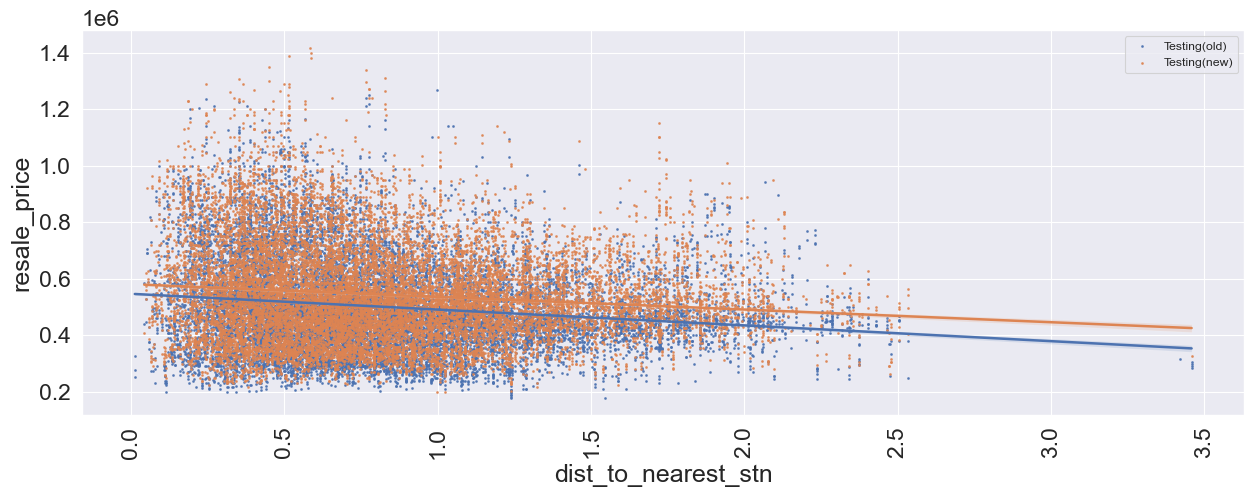

In [ ]:
# Plotting for check for shift in data from old test set to new test set
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.regplot(data=old_test_set , x='dist_to_nearest_stn', y='resale_price', ax=ax, scatter_kws={'s':1}, label='Testing(old)')
sns.regplot(data=new_test_set_2 , x='dist_to_nearest_stn', y='resale_price' , ax=ax, scatter_kws={'s':1}, label='Testing(new)')
ax.legend(loc="best")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

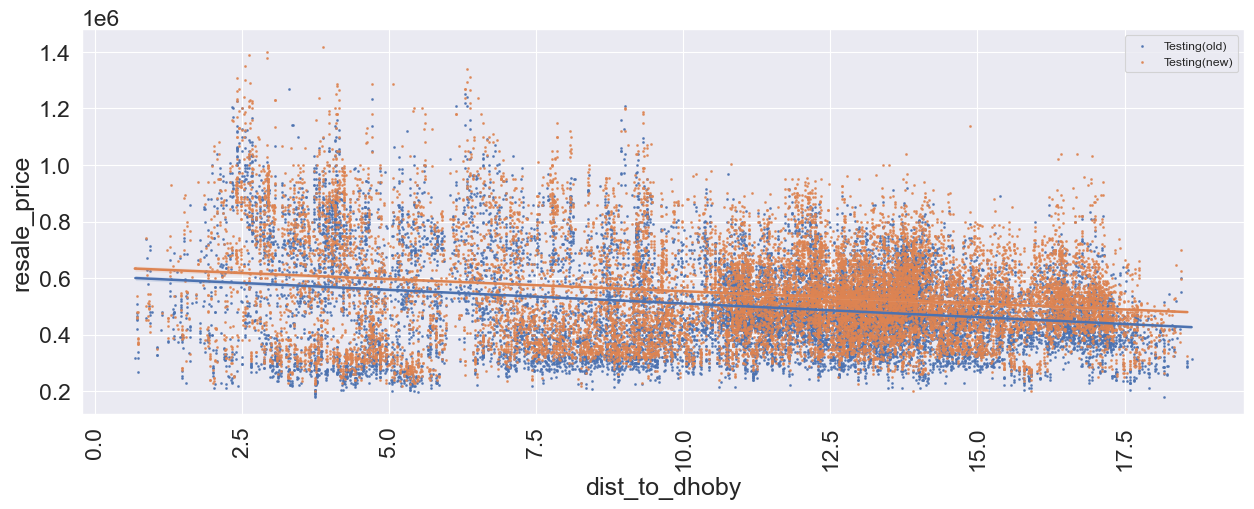

In [ ]:
# Plotting for check for shift in data from old test set to new test set
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.regplot(data=old_test_set , x='dist_to_dhoby', y='resale_price', ax=ax, scatter_kws={'s':1}, label='Testing(old)')
sns.regplot(data=new_test_set_2 , x='dist_to_dhoby', y='resale_price' , ax=ax, scatter_kws={'s':1}, label='Testing(new)')
ax.legend(loc="best")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

It is quite visible that there is shift in dataset when comparing the old test set to new test set from the fact that two linear regression line though parallel, there is an increase in the value of the property for the same X value. i.e. In 2021 if dist_to_dhoby was 10, resale price would have been - 0.54e6, but in 2022 it would be 0.58e6

This shift is quite common for house prices, as there is general appreciation in value of house asset class every year in a growing economy.

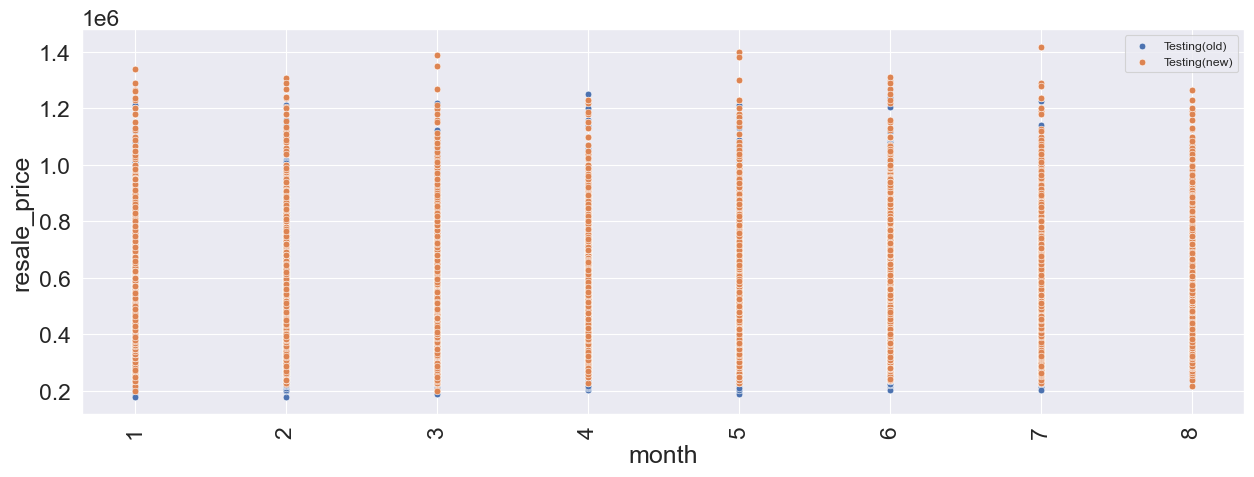

In [ ]:
# Plotting for check for shift in data from old test set to new test set
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.scatterplot(data=old_test_set , x='month', y='resale_price', ax=ax, label='Testing(old)')
sns.scatterplot(data=new_test_set_2 , x='month', y='resale_price' , ax=ax, label='Testing(new)')
ax.legend(loc="best")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

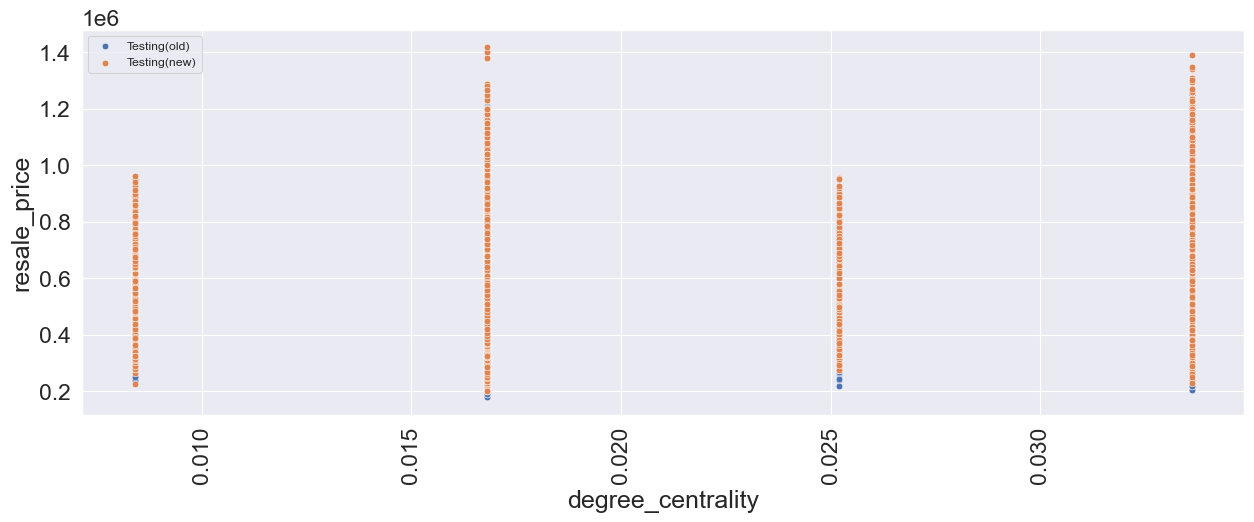

In [ ]:
# Plotting for check for shift in data from old test set to new test set
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.scatterplot(data=old_test_set , x='degree_centrality', y='resale_price', ax=ax, label='Testing(old)')
sns.scatterplot(data=new_test_set_2 , x='degree_centrality', y='resale_price' , ax=ax, label='Testing(new)')
ax.legend(loc="best")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In the Case of features Month and Degree Centrality, it visisble that there is no significant change or shift in dataset, so by removing these features the model performance might not be affected by a big margin.